 <center> <h1> <b> Speech Systems (EE6307) </b> </h1> </center>

<b> Programming Assignment - 01 - Voiced / Unvoiced detection and pitch estimation using auto correlation sequence </b>

Welcome to the first programming assignment in speech systems (EE6307) course. In this programming assignment, you need to code an algorithm to tag the frames of the given speech signal with voiced, unvoiced and silent labels. Also, write an algorithm to compute the pitch periods of the voiced frames. In the upcoming programming assignments, more sophisticated voice activity detection and pitch estimation methods will be assigned as a task. However, in this programming assignment, we request you to use only the autocorrelation sequence to complete the job. Python modules to record the speech data are also included in the notebook. You can either read the speech signals from the drive or record the speech signals using the provided modules for evaluating the performances. 

<b> Instructions </b>
1. Plagiarism is strictly prohibited.
2. Delayed submissions will be penalized with a scaling factor of 0.5 per day.
3. Please DO NOT use any machine learning libraries unless and otherwise specified.


<br/>
<h4>  <b> Framing the signal </b> </h4>

1. The below figure illustrates the concept of framming the signal. 

2. The figure shows that the given speech signal is framed into multiple frames with a frame size of 400 samples and a frameshift of 160 samples.

<img src ="https://raw.githubusercontent.com/Sreeakanth/SpeechSystems/main/Framing.png" width = "1853px" height = "991px" >



In [76]:
import numpy as np
import scipy.io.wavfile
from matplotlib import pyplot as plt

def FrameSig(input, rate, frameSize=0.025,frameShift=0.010,window='hamming'):
    # Takes signal as input and returns a sequence of windowed signals
    '''
    Example :- samplingRate =16000, frameSize= 0.025 sec, frameShift = 0.010 sec
    Input  = (1,16000*5) # The size of the 5 second speech signal with 16 kHz sampling rate 
    Output = (500,400) # Here 500 is the number of frames and 400 is the number of samples in the frame
    '''
    ##################################### 
    # Complete the code
    input  = np.array(input).reshape(1, -1)
    input_length = input.shape[1]

    output = []
    frameLength = int(frameSize * rate)
    shiftLength = int(frameShift * rate)
    i = 0

    while i*shiftLength+frameLength < input_length:
      frame = input[0, i*shiftLength:i*shiftLength+frameLength]
      # applying hamming window
      frame = np.hamming(frameLength).tolist() * frame

      output.append(frame)
      i += 1    

    output = np.array(output)
    # plt.plot(input[0,:])
    # plt.show()
    return output

    #####################################


# testing function
from google.colab import drive
drive.mount('/content/drive')

#wavefile location in drive
wavefile = '/content/drive/My Drive/Record-002.wav'
#wavefile reading
(rate,sig) = scipy.io.wavfile.read(wavefile)
sig=sig-np.mean(sig)

out = FrameSig(sig, rate)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h4> <b> Voiced / Unvoiced detection </b> </h4>


1. Auto correlation sequence of a mean substracted frame x[n] </li> 


 <center> $r_{xx}$[k] = $\frac{1}{r_{xx}[0]}\sum_{n=0}^{N}$ x[n]x[n+k] 
$\;\;\;\;$ k = ...,-2,-1,0,1,2,... </center>


2. The below figure shows the autocorrelation sequence for both voiced and unvoiced frames

2. The figure shows that the voiced or unvoiced decision can be made using the strength of the second peak in the autocorrelation sequence.  </li>

3. If the frame is voiced, The pitch period can be computed from the location of the second peak in the autocorrelation sequence.  </li>

<img src ="https://raw.githubusercontent.com/Sreeakanth/SpeechSystems/master/VoicedUnvoiced.png" width = "800px" height = "400px" >









<br/>
<br/>
<br/>
<br/>


657.5342465753424


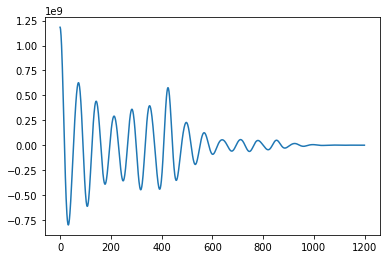

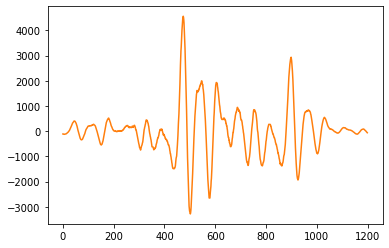

In [77]:
import numpy as np

def AutoCorrelation(frame):
    # Takes frame as input and returns auto correlation sequence of the frame
    '''
    Input = (1,samplingRate*frameDuration)
    Output = (samplingRate*frameDuration) # auto correlation sequence is symmetric
    '''
    ##################################### 
    # Complete the code
    # output= []
    # for k in range(len(frame)):
    #   r_k = 0
    #   for i in range(k, len(frame)):
    #     r_k += frame[i] * frame[i-k]
    #   output.append(r_k)

    # output = output / output[0]
    # return np.array(output)
    myArray = np.array(frame)
    result = np.correlate(myArray, myArray, mode = 'full')
    result = result[result.size // 2 :]
    return result

    #####################################

def get_f0(Rxx,samplingFreq):
    # Extracts the fundamental frequency from the autocorrelation sequence
    # Location of the second peak in the autocorrelation sequence gives the pitch period
    ##################################### 
    # Complete the code

    index = 1
    peaks = []

    while(index<len(Rxx)-1):
      if(Rxx[index] > Rxx[index - 1] and Rxx[index] > Rxx[index + 1]):
        peaks.append((Rxx[index], index))
      index += 1

    if(len(peaks) == 0):
      sampVal, secondPeakIndex = (Rxx[-1], -1)
    else:
      sampVal, secondPeakIndex = max(peaks, key=lambda item:item[0])

    fundamentalFreq = samplingFreq/(secondPeakIndex)

    return fundamentalFreq


    #####################################

def get_voiced(Rxx, threshold, samplingFreq):
    # Returns voiced/unvoiced frame decision from the auto correlation sequence
    ##################################### 
    # Complete the code
    index = 1
    peaks = []

    while(index<len(Rxx)-1):
      if(Rxx[index] > Rxx[index - 1] and Rxx[index] > Rxx[index + 1]):
        peaks.append((Rxx[index], index))
      index += 1

    if(len(peaks) == 0):
      sampVal, secondPeakIndex = (Rxx[-1], -1)
    else:
      sampVal, secondPeakIndex = max(peaks, key=lambda item:item[0])

    
    ##################################### Set fundamental frequency of unvoiced frames as zero or None , This helps in filtering out these frames later
    # Complete the code
      
    if Rxx[secondPeakIndex] > threshold:
      # Voiced : 1
      pitch = get_f0(Rxx, samplingFreq)
      # According to Male Frequency
      if (pitch < 200 and pitch > 0):
        return 1, pitch
      else:
        return 0, -1
    else:
      # UnVoiced : 0
      return 0, -1


    #####################################

def VoicedVSUnvoiced(frame,threshold, samplingFreq):
    # Given a frame , returns whether the frame is voiced or unvoiced
    #If the frame is voiced, The code returns the pitch of the voiced frame
    #If the frame is unvoiced. The code returns some constant ( dummy ) value as pitch ( It will help in filtering out unvoiced frames )
    '''
    Input = signal frame (or) N number of frames
    Output = Binary flag indicating voicing decision and the pitch of the voiced frames
    '''
    ##################################### 
    # Complete the code

    #####################################

    Rxx = AutoCorrelation(frame) #Auto correlation function
    voicedDecision, F0 = get_voiced(Rxx, threshold, samplingFreq)
    #####################################  Filter voiced frames from the voiced/unvoiced decisions computed from the autocorrelation sequence
    # Complete the code

    #####################################
    
    #####################################
    return voicedDecision, F0 # return voiced and unvoiced decision and estimated pitch ( for voiced frames it is actual pitch, for unvoiced frames it is dummy ( either 0 or None ) )

frame = out[200].reshape(-1,)
result = AutoCorrelation(frame)
f0 = get_f0(result, rate)
print(f0)
plt.plot(result)
plt.show()

plt.plot(frame, color ='tab:orange')
plt.show()

# decisions = []

# for i in range(out.shape[0]):
#   decision, f0 = VoicedVSUnvoiced(out[i].reshape(-1,),threshold = 0.55, samplingFreq = rate)
#   arr = (np.ones(rate)*decision).tolist()
#   decisions.extend(arr)

# decisions = np.array(decisions)

# plt.plot(sig/np.max(sig), color ='tab:blue')
# plt.show()

# plt.plot(decisions, color ='tab:orange')
# plt.show()


<h4> <b> Classifying the frame as unvoiced or silence  </b> </h4>
<ul type="circle" >

<li> Unvoiced frames can be discriminated from the silence frames using the signal's energy.   </li> 

<li> Let x[n] be the frame of the signal. The energy of the signal can be computed as </lin>

<br>
<br/>

<center> E = $\sum\limits_{n} | x[n] |^2$  <center\>



In [78]:
import numpy as np

def Energy(frame):
    #Returns the energy of the signal
    energy = 0
    for i in range(len(frame)):
      energy += np.abs(frame[i])**2

    return energy

def SilenceVSUnvoiced(frameEnergy,threshold):
    #Given an unvoiced frame, returns whether the unvoiced frame contains speech information ( fricatives or a few stop consonants etc )  or silence
    # energy = Energy(frame)
    ####################
    # Complete the code
    if frameEnergy > threshold:
      decision = 1
    else:
      decision = 0
      
    ####################
    return decision # returns decision/boolean indicating whether the unvoiced frame belongs to silence or contains speech information 

<h4> <b> Speech Recording </b> </h4>

This section provides the modules to record the speech signal in an online mode.

In [79]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

<h4> <b> Module for recording the speech signal </b> </h4>

1. The below code records the speech signal for 3 sec ( you can change the duration of the recording in the code ) and store it as 'recording.wav' <br/>

2. If you have already recorded or uploaded the file named 'recording.wav', the code uses that file. Otherwise, it records and saves the file with the name 'recording.wav.' 



There is no file in the current directory, please record your voice
Recording started!


<IPython.core.display.Javascript object>

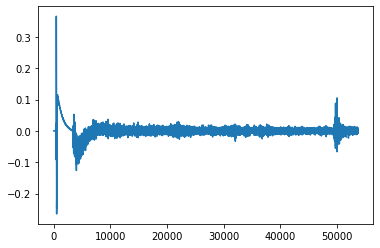

In [80]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.io.wavfile
import io
import os

#### Please comment below line, if you already uploaded the 'recording.wav' in '/content/'
!rm recording.wav

if os.path.isfile('recording.wav'):
    print("wavefile exists, later part of the code uses 'recording.wav' as input speech")
    (rate,sig) = scipy.io.wavfile.read("recording.wav")
    print(len(sig))
else:
    print("There is no file in the current directory, please record your voice")
    print("Recording started!")
    wav = record(3.0) #It will record three seconds of your speech
    wav = wav.set_frame_rate(16000)
    sig=wav.get_array_of_samples()
    samples=np.array(sig).T.astype(np.float32)
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(sig.typecode).max
    scipy.io.wavfile.write('recording.wav', 16000, fp_arr)
    plt.plot(fp_arr)
    plt.show()

<h4> <b> Voiced / Unvoiced detection and pitch estimation </b> </h4>

1. Please use the above-written functions to tag the frames of the given speech signal as voiced, unvoiced or silent frames. 

2. Determine the pitch period and fundamental frequency of the excitation for the voiced frames. 

In [81]:
#All imports
import numpy as np
import scipy.io.wavfile 
import soundfile as sf
from google.colab import drive


###########################
# Read wavefile 
###########################

#Set anyone one of the below falgs as true based on your convenience 
read_from_googleDrive = True
read_from_colab = False #Reads recorded wavefile in colab

if read_from_googleDrive:

    #Mount the drive
    drive.mount('/content/drive')
    #wavefile location in drive
    wavefile = '/content/drive/My Drive/Record-002.wav'
    #wavefile reading
    (rate,sig) = scipy.io.wavfile.read(wavefile)
if read_from_colab:
    #wavefile reading ( By default, the recorded file gets saved as 'recording.wav.' )
    (rate,sig) = scipy.io.wavfile.read('recording.wav')


###########################
# Substract the mean of the speech signal. 
###########################

sig=sig-np.mean(sig)

###########################
# Chunk the signal into N frames with specific frame size and frameShift and, if required, use a windowing function to reduce the boundary effects.
###########################

frameSize=0.025
frameShift=0.010
windowing='hamming'

Frames = FrameSig(sig,rate,frameSize,frameShift,windowing)

###########################
# Voiced / Unvoiced detection and pitch estimation
###########################

PeakThreshold = 0.6         #set the threshold of the second peak in auto correlation sequence

VoicedDecision = []
EstimatedPitch = []

for i in range(len(Frames)):
  voicedOrNot, framePitch = VoicedVSUnvoiced(Frames[i].reshape(-1,), PeakThreshold, rate)
  VoicedDecision.append(voicedOrNot)
  EstimatedPitch.append(framePitch)

VoicedDecision = np.array(VoicedDecision)
EstimatedPitch = np.array(EstimatedPitch)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
###########################
# Classifying the silence from unvoiced frames 
###########################

indices = np.where(VoicedDecision[:] == 0)

UnvoicedFrames = Frames[indices]      #Remove voiced frames and take only unvoiced frames from the VoicedDecision computed using auto correlation sequence

UnvoicedEnergies = []
for i in range(len(UnvoicedFrames)):
  UnvoicedEnergies.append(Energy(UnvoicedFrames[i]))

UnvoicedEnergies = UnvoicedEnergies/np.max(UnvoicedEnergies)

NormalizedEnergyThreshold = 0.1       #set energy threshold for fricative vs silence frame detection from the unvoiced frames
SilenceVSUnvoicedDecision = [SilenceVSUnvoiced(UnvoicedEnergies[i], NormalizedEnergyThreshold) for i in range(len(UnvoicedEnergies))]

SilenceVSUnvoicedDecision = np.array(SilenceVSUnvoicedDecision)

In [83]:
frameDecisions = []

for i in range(len(Frames)):
  if(VoicedDecision[i] == 1):
    frameDecisions.append((1, EstimatedPitch[i]))
  else:
    index = indices[0].tolist().index(i)
    if(SilenceVSUnvoicedDecision[index]==1):
      frameDecisions.append((2, EstimatedPitch[index]))
    else:
      frameDecisions.append((3, EstimatedPitch[index]))

<h4> <b> Tagging the speech signal with voiced, unvoiced, and silent regions </b> </h4>

1. This part of the programming assignment expects you to plot the speech signal with voiced, unvoiced, and silence labels. Based on the computed tags, you may give different colors to parts of the speech signal for better illustrations.

2. We expect you to plot the pitch contour ( tracking the pitch across the frames ) in the voiced regions.   



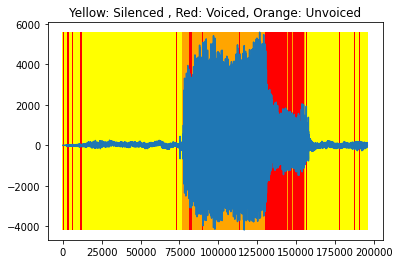

In [84]:
import matplotlib.pyplot as plt

for i in range(len(frameDecisions)):
  size = frameSize * rate
  shift = frameShift * rate

  array = np.arange(i*shift, i*shift + size, dtype='int')
  
  if frameDecisions[i][0] == 1:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='red', lw=2)
  elif frameDecisions[i][0] == 2:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='orange', lw=2)
  elif frameDecisions[i][0] == 3:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='yellow', lw=2)

plt.plot(sig)
plt.title("Yellow: Silenced , Red: Voiced, Orange: Unvoiced")
plt.show()

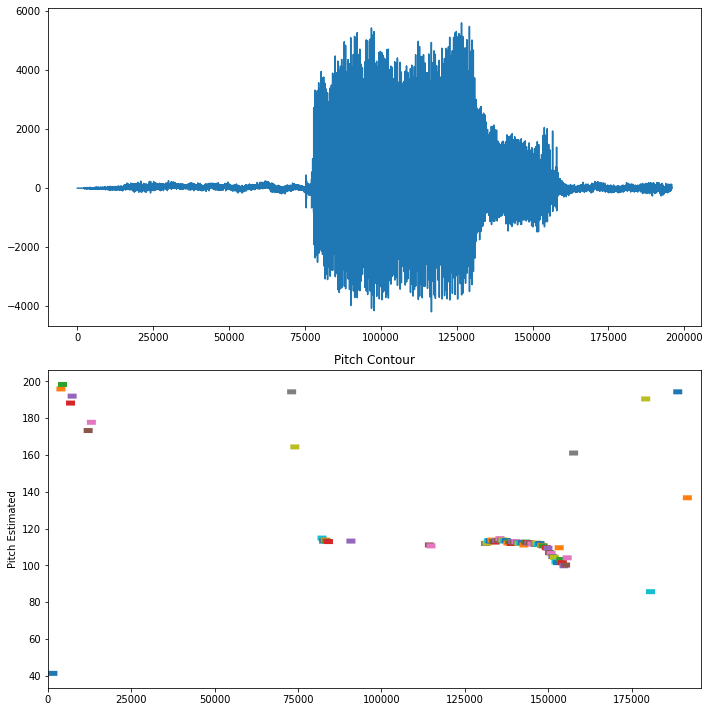

In [85]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(sig)

for i in range(len(frameDecisions)):
  size = frameSize * rate
  shift = frameShift * rate

  indexarray = np.arange(i*shift, i*shift + size, dtype='int')
  array = np.ones(int(size))*frameDecisions[i][1]
  if frameDecisions[i][0] == 1:
    ax[1].plot(indexarray, array, lw=5)

ax[1].set_xlim(0, len(sig))
ax[1].set_ylabel("Pitch Estimated")
plt.title("Pitch Contour")
fig.tight_layout()
plt.show()

## From pitch contour, we can say for voiced frames, estimated pitch lies in range of 110Hz to 120Hz



<br/>
<br/>
<h4> <b> Study of submodules in voice activity detection and pitch estimation  </b> </h4>
<dl>

<dt> <h4> 1. Study the influence of frame size in voice activity detection and pitch estimation. </h4> </dt> 
<dd> <h4> - Consider a different frame sizes and notice the quality of tags   </h4> </dd>
<dt> <h4> 2. Study the influence of pre-processing the wavefile i.e mean substraction and max normalization etc </h4> </dt> 
<dt> <h4> 3. Observe the pitch contour of 'sa-pa-sa' vocals. </h4> </dt> 
<dt> <h4> 4. Why the autocorrelation function rolls off with lag? what other methods can be employed to prevent it? </h4> </dt> 
</dl>

[link to 'sa-pa-sa' vocals ](https://drive.google.com/file/d/1a4tSn7tAsGOGuZH_Yq99z-jM-po231x0/view?usp=sharing)  

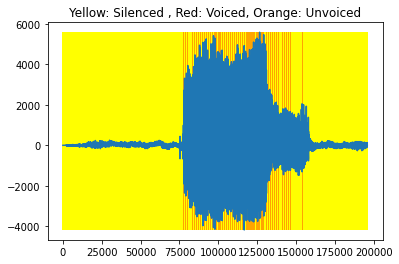

In [86]:
import numpy as np
import matplotlib.pyplot as plt

###################################
#Complete the code
###################################

# 1. Study on frame sizes influence

#wavefile location in drive
wavefile = '/content/drive/My Drive/Record-002.wav'
#wavefile reading
(rate,sig) = scipy.io.wavfile.read(wavefile)

sig = sig-np.mean(sig)

frameSize=0.004 #keep it to be less than pitch period
frameShift=0.002
windowing='hamming'

Frames = FrameSig(sig,rate,frameSize,frameShift,windowing)

###########################
# Voiced / Unvoiced detection and pitch estimation
###########################

PeakThreshold = 0.6         #set the threshold of the second peak in auto correlation sequence

VoicedDecision = []
EstimatedPitch = []

for i in range(len(Frames)):
  voicedOrNot, framePitch = VoicedVSUnvoiced(Frames[i].reshape(-1,), PeakThreshold, rate)
  VoicedDecision.append(voicedOrNot)
  EstimatedPitch.append(framePitch)

VoicedDecision = np.array(VoicedDecision)
EstimatedPitch = np.array(EstimatedPitch)

###########################
# Classifying the silence from unvoiced frames 
###########################

indices = np.where(VoicedDecision[:] == 0)

UnvoicedFrames = Frames[indices]      #Remove voiced frames and take only unvoiced frames from the VoicedDecision computed using auto correlation sequence

UnvoicedEnergies = []
for i in range(len(UnvoicedFrames)):
  UnvoicedEnergies.append(Energy(UnvoicedFrames[i]))

UnvoicedEnergies = UnvoicedEnergies/np.max(UnvoicedEnergies)

NormalizedEnergyThreshold = 0.1       #set energy threshold for fricative vs silence frame detection from the unvoiced frames
SilenceVSUnvoicedDecision = [SilenceVSUnvoiced(UnvoicedEnergies[i], NormalizedEnergyThreshold) for i in range(len(UnvoicedEnergies))]

SilenceVSUnvoicedDecision = np.array(SilenceVSUnvoicedDecision)

frameDecisions = []

for i in range(len(Frames)):
  if(VoicedDecision[i] == 1):
    frameDecisions.append((1, EstimatedPitch[i]))
  else:
    index = indices[0].tolist().index(i)
    if(SilenceVSUnvoicedDecision[index]==1):
      frameDecisions.append((2, EstimatedPitch[index]))
    else:
      frameDecisions.append((3, EstimatedPitch[index]))

for i in range(len(frameDecisions)):
  size = frameSize * rate
  shift = frameShift * rate

  array = np.arange(i*shift, i*shift + size, dtype='int')
  
  if frameDecisions[i][0] == 1:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='red', lw=2)
  elif frameDecisions[i][0] == 2:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='orange', lw=2)
  elif frameDecisions[i][0] == 3:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='yellow', lw=2)

plt.plot(sig)
plt.title("Yellow: Silenced , Red: Voiced, Orange: Unvoiced")
plt.show()

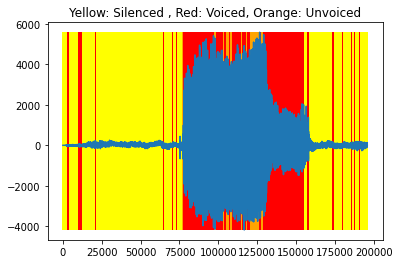

In [87]:
# increasing frameSize to around 32ms

#wavefile location in drive
wavefile = '/content/drive/My Drive/Record-002.wav'
#wavefile reading
(rate,sig) = scipy.io.wavfile.read(wavefile)

sig = sig-np.mean(sig)

frameSize=0.032 #keep it to be more than pitch period
frameShift=0.010
windowing='hamming'

Frames = FrameSig(sig,rate,frameSize,frameShift,windowing)

###########################
# Voiced / Unvoiced detection and pitch estimation
###########################

PeakThreshold = 0.6         #set the threshold of the second peak in auto correlation sequence

VoicedDecision = []
EstimatedPitch = []

for i in range(len(Frames)):
  voicedOrNot, framePitch = VoicedVSUnvoiced(Frames[i].reshape(-1,), PeakThreshold, rate)
  VoicedDecision.append(voicedOrNot)
  EstimatedPitch.append(framePitch)

VoicedDecision = np.array(VoicedDecision)
EstimatedPitch = np.array(EstimatedPitch)

###########################
# Classifying the silence from unvoiced frames 
###########################

indices = np.where(VoicedDecision[:] == 0)

UnvoicedFrames = Frames[indices]      #Remove voiced frames and take only unvoiced frames from the VoicedDecision computed using auto correlation sequence

UnvoicedEnergies = []
for i in range(len(UnvoicedFrames)):
  UnvoicedEnergies.append(Energy(UnvoicedFrames[i]))

UnvoicedEnergies = UnvoicedEnergies/np.max(UnvoicedEnergies)

NormalizedEnergyThreshold = 0.1       #set energy threshold for fricative vs silence frame detection from the unvoiced frames
SilenceVSUnvoicedDecision = [SilenceVSUnvoiced(UnvoicedEnergies[i], NormalizedEnergyThreshold) for i in range(len(UnvoicedEnergies))]

SilenceVSUnvoicedDecision = np.array(SilenceVSUnvoicedDecision)

frameDecisions = []

for i in range(len(Frames)):
  if(VoicedDecision[i] == 1):
    frameDecisions.append((1, EstimatedPitch[i]))
  else:
    index = indices[0].tolist().index(i)
    if(SilenceVSUnvoicedDecision[index]==1):
      frameDecisions.append((2, EstimatedPitch[index]))
    else:
      frameDecisions.append((3, EstimatedPitch[index]))

for i in range(len(frameDecisions)):
  size = frameSize * rate
  shift = frameShift * rate

  array = np.arange(i*shift, i*shift + size, dtype='int')
  
  if frameDecisions[i][0] == 1:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='red', lw=2)
  elif frameDecisions[i][0] == 2:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='orange', lw=2)
  elif frameDecisions[i][0] == 3:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='yellow', lw=2)

plt.plot(sig)
plt.title("Yellow: Silenced , Red: Voiced, Orange: Unvoiced")
plt.show()

## With increased frame size which captures 4-5 times of pitch periods, gives better prediction on voiced regions. Systems is highly inaccurate for frame size of less than one pitch period

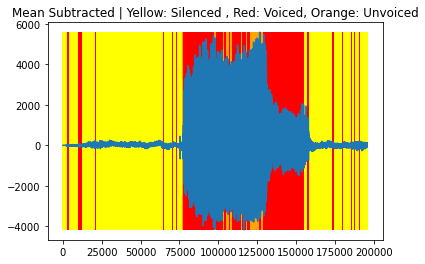

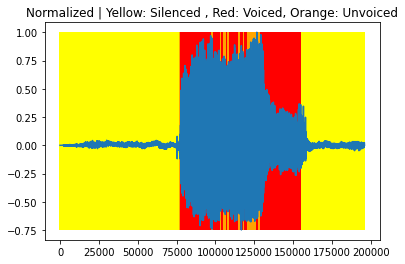

In [90]:
## Study on preprocessing wavfile

#wavefile location in drive
wavefile = '/content/drive/My Drive/Record-002.wav'
#wavefile reading
(rate,sig) = scipy.io.wavfile.read(wavefile)

# with mean subtraction
sig=sig-np.mean(sig)

# increasing frameSize to around 32ms

frameSize=0.032 #keep it to be more than pitch period
frameShift=0.010
windowing='hamming'

Frames = FrameSig(sig,rate,frameSize,frameShift,windowing)

###########################
# Voiced / Unvoiced detection and pitch estimation
###########################

PeakThreshold = 0.6         #set the threshold of the second peak in auto correlation sequence

VoicedDecision = []
EstimatedPitch = []

for i in range(len(Frames)):
  voicedOrNot, framePitch = VoicedVSUnvoiced(Frames[i].reshape(-1,), PeakThreshold, rate)
  VoicedDecision.append(voicedOrNot)
  EstimatedPitch.append(framePitch)

VoicedDecision = np.array(VoicedDecision)
EstimatedPitch = np.array(EstimatedPitch)

###########################
# Classifying the silence from unvoiced frames 
###########################

indices = np.where(VoicedDecision[:] == 0)

UnvoicedFrames = Frames[indices]      #Remove voiced frames and take only unvoiced frames from the VoicedDecision computed using auto correlation sequence

UnvoicedEnergies = []
for i in range(len(UnvoicedFrames)):
  UnvoicedEnergies.append(Energy(UnvoicedFrames[i]))

UnvoicedEnergies = UnvoicedEnergies/np.max(UnvoicedEnergies)

NormalizedEnergyThreshold = 0.1       #set energy threshold for fricative vs silence frame detection from the unvoiced frames
SilenceVSUnvoicedDecision = [SilenceVSUnvoiced(UnvoicedEnergies[i], NormalizedEnergyThreshold) for i in range(len(UnvoicedEnergies))]

SilenceVSUnvoicedDecision = np.array(SilenceVSUnvoicedDecision)

frameDecisions = []

for i in range(len(Frames)):
  if(VoicedDecision[i] == 1):
    frameDecisions.append((1, EstimatedPitch[i]))
  else:
    index = indices[0].tolist().index(i)
    if(SilenceVSUnvoicedDecision[index]==1):
      frameDecisions.append((2, EstimatedPitch[index]))
    else:
      frameDecisions.append((3, EstimatedPitch[index]))

for i in range(len(frameDecisions)):
  size = frameSize * rate
  shift = frameShift * rate

  array = np.arange(i*shift, i*shift + size, dtype='int')
  
  if frameDecisions[i][0] == 1:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='red', lw=2)
  elif frameDecisions[i][0] == 2:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='orange', lw=2)
  elif frameDecisions[i][0] == 3:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='yellow', lw=2)

plt.plot(sig)
plt.title("Mean Subtracted | Yellow: Silenced , Red: Voiced, Orange: Unvoiced")
plt.show()

# with normalization

#wavefile location in drive
wavefile = '/content/drive/My Drive/Record-002.wav'
#wavefile reading
(rate,sig) = scipy.io.wavfile.read(wavefile)

sig=sig/max(sig)

# increasing frameSize to around 32ms

frameSize=0.032 #keep it to be more than pitch period
frameShift=0.010
windowing='hamming'

Frames = FrameSig(sig,rate,frameSize,frameShift,windowing)

###########################
# Voiced / Unvoiced detection and pitch estimation
###########################

PeakThreshold = 0.6         #set the threshold of the second peak in auto correlation sequence

VoicedDecision = []
EstimatedPitch = []

for i in range(len(Frames)):
  voicedOrNot, framePitch = VoicedVSUnvoiced(Frames[i].reshape(-1,), PeakThreshold, rate)
  VoicedDecision.append(voicedOrNot)
  EstimatedPitch.append(framePitch)

VoicedDecision = np.array(VoicedDecision)
EstimatedPitch = np.array(EstimatedPitch)

###########################
# Classifying the silence from unvoiced frames 
###########################

indices = np.where(VoicedDecision[:] == 0)

UnvoicedFrames = Frames[indices]      #Remove voiced frames and take only unvoiced frames from the VoicedDecision computed using auto correlation sequence

UnvoicedEnergies = []
for i in range(len(UnvoicedFrames)):
  UnvoicedEnergies.append(Energy(UnvoicedFrames[i]))

UnvoicedEnergies = UnvoicedEnergies/np.max(UnvoicedEnergies)

NormalizedEnergyThreshold = 0.1       #set energy threshold for fricative vs silence frame detection from the unvoiced frames
SilenceVSUnvoicedDecision = [SilenceVSUnvoiced(UnvoicedEnergies[i], NormalizedEnergyThreshold) for i in range(len(UnvoicedEnergies))]

SilenceVSUnvoicedDecision = np.array(SilenceVSUnvoicedDecision)

frameDecisions = []

for i in range(len(Frames)):
  if(VoicedDecision[i] == 1):
    frameDecisions.append((1, EstimatedPitch[i]))
  else:
    index = indices[0].tolist().index(i)
    if(SilenceVSUnvoicedDecision[index]==1):
      frameDecisions.append((2, EstimatedPitch[index]))
    else:
      frameDecisions.append((3, EstimatedPitch[index]))

for i in range(len(frameDecisions)):
  size = frameSize * rate
  shift = frameShift * rate

  array = np.arange(i*shift, i*shift + size, dtype='int')
  
  if frameDecisions[i][0] == 1:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='red', lw=2)
  elif frameDecisions[i][0] == 2:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='orange', lw=2)
  elif frameDecisions[i][0] == 3:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='yellow', lw=2)

plt.plot(sig)
plt.title("Normalized | Yellow: Silenced , Red: Voiced, Orange: Unvoiced")

plt.show()

## SA-PA-SA Analysis

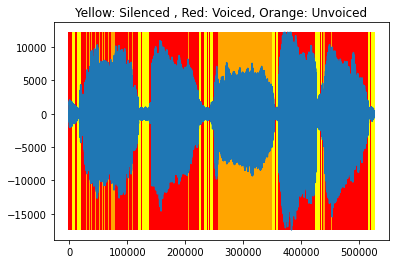

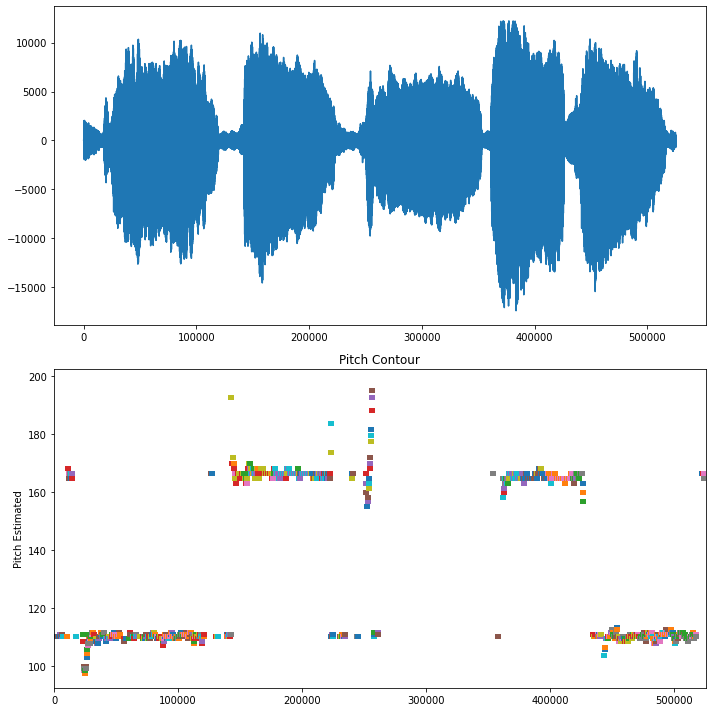

In [89]:
#wavefile location in drive
wavefile = '/content/sa-pa-sa.wav'
#wavefile reading
(rate,sig) = scipy.io.wavfile.read(wavefile)

sig = sig-np.mean(sig)

frameSize=0.032 #keep it to be more than pitch period
frameShift=0.010
windowing='hamming'

Frames = FrameSig(sig,rate,frameSize,frameShift,windowing)

###########################
# Voiced / Unvoiced detection and pitch estimation
###########################

PeakThreshold = 0.6         #set the threshold of the second peak in auto correlation sequence

VoicedDecision = []
EstimatedPitch = []

for i in range(len(Frames)):
  voicedOrNot, framePitch = VoicedVSUnvoiced(Frames[i].reshape(-1,), PeakThreshold, rate)
  VoicedDecision.append(voicedOrNot)
  EstimatedPitch.append(framePitch)

VoicedDecision = np.array(VoicedDecision)
EstimatedPitch = np.array(EstimatedPitch)

###########################
# Classifying the silence from unvoiced frames 
###########################

indices = np.where(VoicedDecision[:] == 0)

UnvoicedFrames = Frames[indices]      #Remove voiced frames and take only unvoiced frames from the VoicedDecision computed using auto correlation sequence

UnvoicedEnergies = []
for i in range(len(UnvoicedFrames)):
  UnvoicedEnergies.append(Energy(UnvoicedFrames[i]))

UnvoicedEnergies = UnvoicedEnergies/np.max(UnvoicedEnergies)

NormalizedEnergyThreshold = 0.1       #set energy threshold for fricative vs silence frame detection from the unvoiced frames
SilenceVSUnvoicedDecision = [SilenceVSUnvoiced(UnvoicedEnergies[i], NormalizedEnergyThreshold) for i in range(len(UnvoicedEnergies))]

SilenceVSUnvoicedDecision = np.array(SilenceVSUnvoicedDecision)

frameDecisions = []

for i in range(len(Frames)):
  if(VoicedDecision[i] == 1):
    frameDecisions.append((1, EstimatedPitch[i]))
  else:
    index = indices[0].tolist().index(i)
    if(SilenceVSUnvoicedDecision[index]==1):
      frameDecisions.append((2, EstimatedPitch[index]))
    else:
      frameDecisions.append((3, EstimatedPitch[index]))

for i in range(len(frameDecisions)):
  size = frameSize * rate
  shift = frameShift * rate

  array = np.arange(i*shift, i*shift + size, dtype='int')
  
  if frameDecisions[i][0] == 1:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='red', lw=2)
  elif frameDecisions[i][0] == 2:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='orange', lw=2)
  elif frameDecisions[i][0] == 3:
    plt.vlines(x=array, ymin=min(sig), ymax=max(sig), colors='yellow', lw=2)

plt.plot(sig)
plt.title("Yellow: Silenced , Red: Voiced, Orange: Unvoiced")
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(sig)

for i in range(len(frameDecisions)):
  size = frameSize * rate
  shift = frameShift * rate

  indexarray = np.arange(i*shift, i*shift + size, dtype='int')
  array = np.ones(int(size))*frameDecisions[i][1]
  if frameDecisions[i][0] == 1:
    ax[1].plot(indexarray, array, lw=5)

ax[1].set_xlim(0, len(sig))
ax[1].set_ylabel("Pitch Estimated")
plt.title("Pitch Contour")
fig.tight_layout()
plt.show()

## Analysis for Sa-Pa-Sa waveform

We can observe that our detection algorithm works well in identifying "sa" & "pa" as voiced regions with unvoiced regions at the start of /s/ & /p/ of waveform. Also it is able to distinguish the slienced regions present in signal.

From the pitch contour, we can observe how pitch is getting switched between two octaves, one octave at ~115Hz) and another at ~165Hz). Due to this frequency range (<200Hz) and such accurate switching, we can confirm that these are vocals of a **professional male singer**.

## Why the autocorrelation function rolls off with lag? what other methods can be employed to prevent it?

ACF Function rolls off with lag because, a signal correlates with itself at the lag=0 which gives the maximum elementwise product and then as lag increases signal gets correlated with its shifted versions. Due to disimilarty as the shift increases, elementwise product decreases as lag increases.